In [1]:
%cd ..

/home/dawood/Workspace/compoundGAN


In [12]:
import torch
import dgl
import networkx as nx
from torch.utils.data import DataLoader
from tqdm import tqdm

from data.zinc import ZINC250K, ZINC_collate, Library
from data import utils
from models.gcn import GCN

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

from matplotlib import pyplot as plt
plt.style.use('seaborn-deep')

%matplotlib inline
%load_ext line_profiler

atom_list = [i for i in Library.atom_list]
atom_list.append('END')

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [3]:
model = GCN(59, 13, 256, [64, 128, 128])

In [4]:
dataset = ZINC250K('/home/dawood/Datasets/ZINC250K/data.csv')
dataset.max_seq_len = 19
dataset.gumbel_temp = 0.1

In [5]:
dataloader = DataLoader(dataset, 100, shuffle=True, collate_fn=ZINC_collate)

In [6]:
num_nodes = []
for i, G in tqdm(enumerate(dataloader)):
    #num_nodes.extend(g.batch_num_nodes)
    break

0it [00:00, ?it/s]

C[C@@H]1CN(S(=O)(=O)N2CCC(OCc3ccc(F)cc3)CC2)[C@H](C)CO1

[16, 17, 18, 15, 19, 14, 13, 12, 11, 10, 20, 9, 21, 8, 7, 4, 5, 6, 3, 22, 2, 23, 24, 1, 25, 0]
C[C@@H](Sc1ccccn1)C(=O)NCCNC(=O)c1ccccc1Cl

[19, 20, 18, 21, 17, 22, 15, 23, 16, 14, 13, 12, 11, 9, 10, 1, 2, 0, 3, 4, 8, 5, 7, 6]
Cc1oc2ncnc(N3CCC[C@H](C(=O)Nc4cccc(C(F)(F)F)c4)C3)c2c1C

[7, 8, 27, 6, 9, 26, 28, 3, 5, 10, 12, 29, 1, 4, 2, 11, 13, 0, 14, 15, 16, 17, 25, 18, 20, 19, 21, 22, 23, 24]
C[C@H](O)CNC(=O)Cn1c(C2CCCCC2)nc2ccccc21

[19, 20, 18, 21, 17, 22, 16, 8, 9, 7, 10, 5, 11, 15, 6, 4, 12, 14, 3, 13, 1, 2, 0]
C/N=C1\S/C(=C/C(=O)OC)C(=O)N1C

[9, 8, 6, 7, 5, 4, 10, 3, 11, 12, 2, 13, 1, 0]
CCCc1cc(C(=O)Nc2cccc(CN(C)C(C)=O)c2)[nH]n1

[6, 7, 8, 5, 9, 21, 4, 10, 20, 22, 3, 11, 13, 2, 12, 14, 1, 15, 0, 16, 17, 18, 19]
CC(C)CCOCC[NH+]1CCC(C(=O)N2C[C@H](C)O[C@H](C)C2)CC1

[15, 16, 14, 17, 18, 12, 21, 19, 13, 11, 20, 22, 10, 23, 9, 8, 7, 6, 5, 4, 3, 1, 2, 0]
CCc1nn(C)cc1CNC(=O)Nc1cc(C)ccc1-n1cc(C)cn1

[5, 4, 6, 3, 7, 2, 8, 1, 9, 0, 10,

KeyboardInterrupt: 

# %lprun -f utils.mol2graph dataset[10]
nx.draw(G.to_networkx(), pos=nx.kamada_kawai_layout(G.to_networkx()))

C[C@@H]1C[C@@H]1C(=O)N(Cc1ccc(F)cc1F)C1CC1

[8, 9, 7, 14, 10, 6, 15, 13, 11, 16, 4, 12, 17, 18, 5, 3, 1, 2, 0]


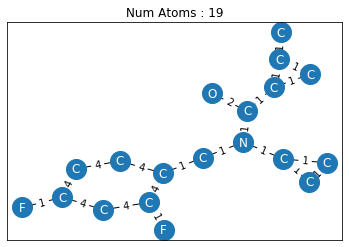

In [13]:
#plt.figure(figsize=(50, 50))
G = dataset[206170]
atoms = [atom_list[i] for i in G.ndata['feats'][:, :43].argmax(1).data.cpu()]
G_pred = nx.Graph()
for i, atom in enumerate(atoms):
    G_pred.add_node(i, atom='%s'%(atom))

edge_pred = G.edata['feats'][:, :5].argmax(1).data.cpu()
#print(edge_pred)
edge_pred_score = G.edata['feats'][:, :5].max(1)[0].data.cpu()

edges = []
edge_types = []
edge_start = [i.item() for i in G.edges()[0]]
edge_end = [i.item() for i in G.edges()[1]]
edge_num = 0
for i,j in zip(edge_start, edge_end):
    if (i == j): 
        edge_num += 1
        continue
    if edge_pred[edge_num] > 0:
        edges.append((i, j))
        edge_types.append(edge_pred[edge_num].item())
    edge_num += 1
        
for i in range(len(edges)):
    G_pred.add_edge(*edges[i], bond_type=edge_types[i])

pos = nx.drawing.nx_agraph.graphviz_layout(G_pred)
node_labels = nx.get_node_attributes(G_pred, 'atom')
nx.draw_networkx(G_pred, pos, font_color='w', node_size=400, labels=node_labels)
#
#nx.draw_networkx_labels(G_pred, pos, labels=node_labels)

edge_labels = nx.get_edge_attributes(G_pred, 'bond_type')
nx.draw_networkx_edge_labels(G_pred, pos, edge_labels=edge_labels)

plt.title('Num Atoms : %d'%(len(atoms)))
plt.show()

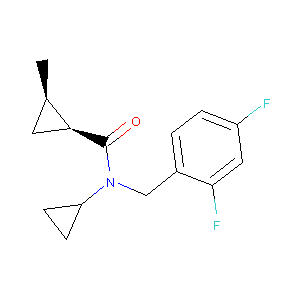

In [16]:
Draw.MolToImage(Chem.MolFromSmiles('C[C@@H]1C[C@@H]1C(=O)N(Cc1ccc(F)cc1F)C1CC1'))

In [48]:
G.ndata['feats'][:, :43]

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

In [17]:
g_copy = dgl.batch([dgl.DGLGraph(_g._graph) for _g in dgl.unbatch(g)])
g_copy, g

NameError: name 'g' is not defined

In [ ]:
G.ndata['feats'][:, :43]

In [ ]:
mask.shape

In [ ]:
len(atom_y)